### Exploratory Data Analysis Project on King County Houses

**Identification of customer's needs/wishes**

The stakeholder for this project is Jacob Philipps. 
He is a buyer with an **unlimited budget**. Therefore, no selection by price will be excluded.

__He wishes:__
- 4+ bathrooms --> exclusive bathroom as a fixed parameter 
- big lot (with the option to build a tennis court & a pool) --> minimal size: tennis court = 60*120 ft + pool
- close to golf resort --> check maps
- no waterfront  --> exclude houses with waterfront
- optional: historic house --> yr_built < average --> historical cut-off in seattle?

**HYPOTHESIS: Do we need a multi-storey house to include a tennis court & a pool in the lot?**

1. Does the space for living (sqft_living) increase with more floors?
2. Is the garden size of the lot increasing, if we have a house with several floors?
3. Can we build a tennis court and a pool in the basement?
4. Are there houses close to a golf yard?

The goal is to recommend three houses.

In [2]:
# horizontal scrolling if working with firefox
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

**Load packages**

In [1]:
# packages for eda
import pandas as pd
import numpy as np
import missingno as mso

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# visualization settings
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings("ignore")

**First we need to fetch the data from the King Countys dataset from the SQL database**

In [3]:
#from dotenv import load_dotenv
#%run ./Fetching_from_SQL.ipynb

In [4]:
# import data into a pandas df
df_house = pd.read_csv('data/king_county_data.csv')
df = df_house.copy()
df.columns

Index(['date', 'price', 'house_id', 'id', 'id.1', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

**Data Cleaning**
- check for duplicates
- check for missing values
- check for reasonable values in each feature

For better clarity, the notebook is called without showing the content by `%%capture`.

In [5]:
%%capture
%run Data_Cleaning.ipynb

In [6]:
df.head()

,date,price,house_id,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.00,7129300520,1,3.00,1.00,1180.00,5650.00,1.00,NaN,...,7,1180.00,0.00,1955,0.00,98178,47.51,-122.26,1340.00,5650.00
1,2014-12-09,538000.00,6414100192,2,3.00,2.25,2570.00,7242.00,2.00,0.00,...,7,2170.00,400.00,1951,1991.00,98125,47.72,-122.32,1690.00,7639.00
2,2015-02-25,180000.00,5631500400,3,2.00,1.00,770.00,10000.00,1.00,0.00,...,6,770.00,0.00,1933,0.00,98028,47.74,-122.23,2720.00,8062.00
3,2014-12-09,604000.00,2487200875,4,4.00,3.00,1960.00,5000.00,1.00,0.00,...,7,1050.00,910.00,1965,0.00,98136,47.52,-122.39,1360.00,5000.00
4,2015-02-18,510000.00,1954400510,5,3.00,2.00,1680.00,8080.00,1.00,0.00,...,8,1680.00,0.00,1987,0.00,98074,47.62,-122.05,1800.00,7503.00


**Hypothesis  1:  Does the space for living (sqft_living) increase with more floors?**

To check this, first we want to have a descriptive overview of the variable sqft_living

<Axes: ylabel='Frequency'>

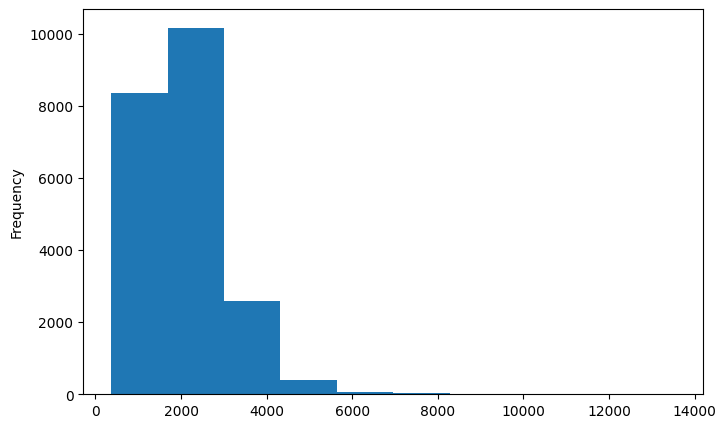

In [7]:
# histogram of sqft_living
df.sqft_living.plot(kind='hist')

It seems that the majority of houses provides a living area between 2000 and 3000 sqft. To have the exact numbers of the mean, the median and the mode, we analyze it further.

In [8]:
df.sqft_living.describe()

count   21597.00
mean     2080.32
std       918.11
min       370.00
25%      1430.00
50%      1910.00
75%      2550.00
max     13540.00
Name: sqft_living, dtype: float64

Visualization of the relationship of sqft_living and floors.

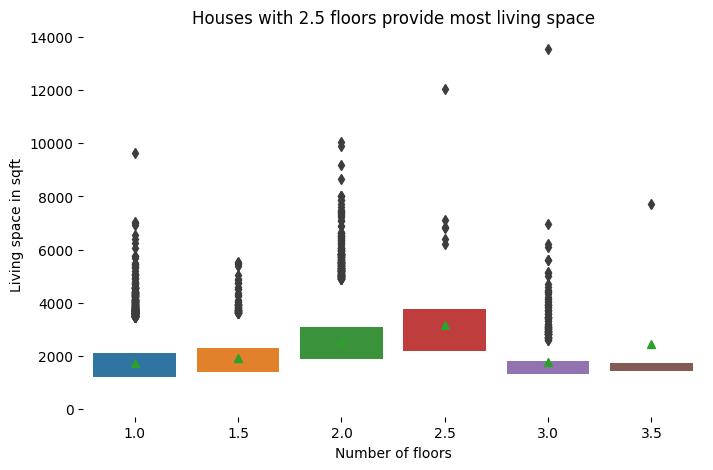

In [34]:
sns.boxplot(x="floors", y="sqft_living",
                linewidth=0,
                data=df,showmeans=True).set(
    title='Houses with 2.5 floors provide most living space',
    xlabel='Number of floors',
    ylabel='Living space in sqft')

sns.despine(bottom=True, left=True) #remove the borders

The plot shows an increasing living space by floors at least up to 2,5 floors. Houses of 3 and 3.5 floors seem to provide less space. Also values for mean and confidence intervalls are included. Exact values can be seen if we print the table below.

In [31]:
m=df.groupby('floors')['sqft_living'].mean() #Mean values 
m 

floors
1.00   1732.62
1.50   1907.88
2.00   2571.41
2.50   3145.43
3.00   1789.42
3.50   2440.00
Name: sqft_living, dtype: float64

Now let us switch the perspective and focus on the size of the lot, regarding the living area. Furthermore, take the wishes for the bathroom and waterfront into account, when looking for an adequate lot.

**Hypothesis 2: Is the garden size of the lot increasing, if we have a house with several floors?**

In [73]:
# adapt df to philips wishes: no waterfront and 4+ bathrooms and save in a new dataframe 
#called df_4bath, sorted by bathrooms
df_4bath=df.query('waterfront != 1 and bathrooms > 4').sort_values('bathrooms') 

# optional: save to csv.file
# df_4bath.to_csv('data/df_4bath.csv',index=False)
df_4bath.info()


<class 'pandas.core.frame.DataFrame'>
Index: 249 entries, 11741 to 12764
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           249 non-null    datetime64[ns]
 1   price          249 non-null    float64       
 2   house_id       249 non-null    int64         
 3   id             249 non-null    int64         
 4   bedrooms       249 non-null    float64       
 5   bathrooms      249 non-null    float64       
 6   sqft_living    249 non-null    float64       
 7   sqft_lot       249 non-null    float64       
 8   floors         249 non-null    float64       
 9   waterfront     225 non-null    float64       
 10  view           247 non-null    float64       
 11  condition      249 non-null    int64         
 12  grade          249 non-null    int64         
 13  sqft_above     249 non-null    float64       
 14  sqft_basement  243 non-null    float64       
 15  yr_built       249 non

First of all, 249 houses meet the requirements of 4+ bathrooms and no waterfront. But for 24 houses the value for the waterfront is not clear, as it is missing.
To check the relationship between the size of the lot and the living space provided, the following plot is created. 

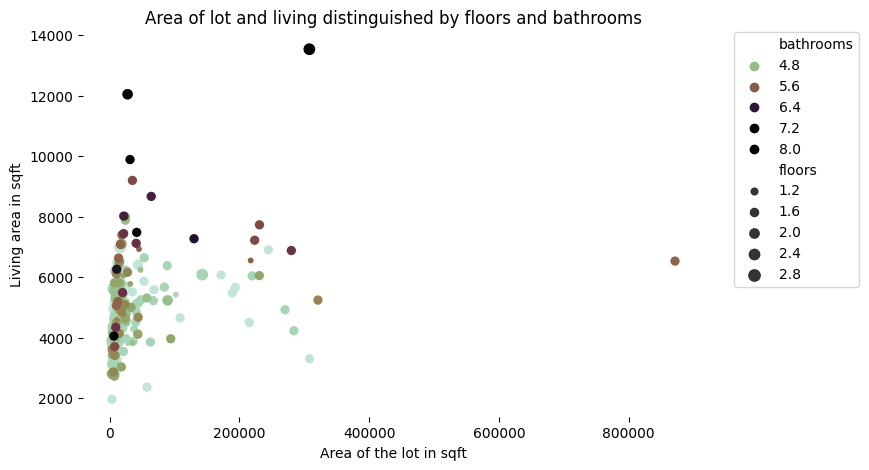

In [10]:
# new plot with adapted data: plot sqft_lot vs sqft_living with different styles for floors and hue bathrooms
b=sns.scatterplot(y="sqft_living", x="sqft_lot",
                size="floors", hue="bathrooms",
                palette="ch:r=0.89,d=-0.4", # r for rotation of the hue wheel, d for intesity of the darkest colour, both between 0 and 1, 0.3_r = umgedreht (hellstes = höchstes)
                linewidth=0,
                legend='brief',# not every entry gets a marker in the legend, otherwise use full
                data=df_4bath).set(title='Area of lot and living distinguished by floors and bathrooms', xlabel='Area of the lot in sqft', ylabel='Living area in sqft')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # move legend to right border
sns.despine(left=True, bottom=True)

This plot shows that most of the houses which meet Philipps wishes of min 4 bathrooms and no waterfront, have a lot size smaller than 200.000 sqft. Additionally most of them seem to have between 4.25 and 6 bathrooms with 1.5 to 2.5 floors.

Moreover, one house with an exceptional big lot is obvious, which will be excluded in the next plot for the relationship between size of the garden (=lot-sqft_floor) and the size of the lot. 

In [38]:
#outlier
df_4bath.query('sqft_lot == 871200')

,date,price,house_id,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_floor,liv_lot,sqft_garden
20436,2015-04-15,1600000.00,1125079111,20437,4.00,5.50,6530.00,871200.00,2.00,0.00,...,2008,0.00,98014,47.66,-121.88,1280.00,858132.00,3265.00,0.37,867935.00


In [74]:
# create a new column to get the size per floor use sqft_above to exclude basement
df_4bath.eval('sqft_floor = sqft_above/floors', inplace = True) #already included in df_4bath.csv
# create a new column for the size of the garden
df_4bath.eval('sqft_garden = sqft_lot - sqft_floor', inplace = True) # included in df_4bath.csv

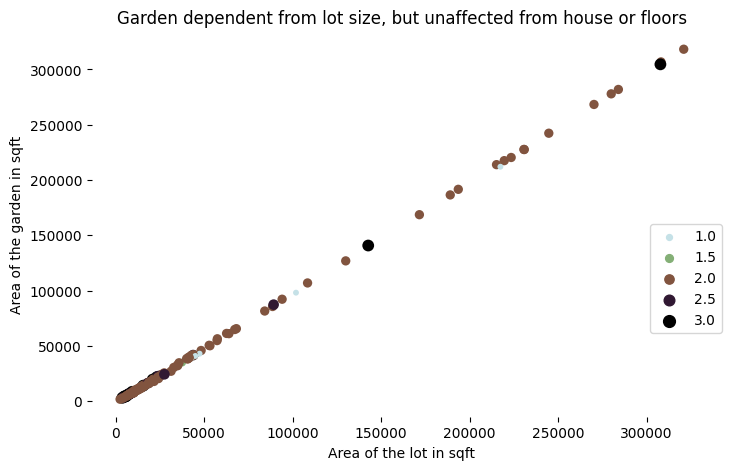

In [41]:
# plot garden size vs lot size hue = floors
sns.scatterplot(y="sqft_garden", x="sqft_lot",
                size="floors", hue="floors",
                palette="ch:r=0.99,d=-0.1",
                linewidth=0,
                data=df_4bath.query('sqft_lot < 871200')).set(
                    title='Garden dependent from lot size, but unaffected from house or floors', 
                    xlabel='Area of the lot in sqft', 
                    ylabel='Area of the garden in sqft')

plt.legend(bbox_to_anchor=(0.9, 0.5), loc=2, borderaxespad=0.) 
sns.despine(left=True, bottom=True)

The area of the lot and the garden seems to be very strong correlated, as the size for the house (sqft_floor) is too small to change the relationship. So independently of the number of floors, the garden increases with increasing size of the lot.

**Hypothesis 3: Is the size of basement (sqft_basement) big enough for building a tennis court or a pool in there?**
Size of a tennis court 9100 sqft (130*70 ft), minimal size of a tennis court 7100 ft (120*60 ft)
Size of a luxury pool to swim and dive 640sqft (40*16 ft)

So lets check the size of the floors and the basement!

In [48]:
print(df_4bath.query('sqft_floor >= 7200'), df_4bath.query('sqft_basement >= 7200'), "maximum size of the basement", df_4bath.sqft_basement.max())

Empty DataFrame
Columns: [date, price, house_id, id, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15, sqft_floor, liv_lot, sqft_garden]
Index: []

[0 rows x 25 columns] Empty DataFrame
Columns: [date, price, house_id, id, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15, sqft_floor, liv_lot, sqft_garden]
Index: []

[0 rows x 25 columns] maximum size of the basement 4130.0


It does not seem possible to have a tennis court inside of the building, as the maximum basement counts 4130 sqft.
So the garden/lot needs to be big enough.
Lets check for the pool.

In [53]:
df_4bath.query('sqft_basement >= 640')['id'].value_counts().sum()


140

In 140 houses it should be possible to install a pool in the basement. Let's check their garden size for the tennis court, floor area and bathroom availability.

In [55]:
# cut off of houses, which are too small for a tennis court
df_pool_tennis = df_4bath.query('sqft_basement >=640 and sqft_garden > 9100')
df_pool_tennis

#save as csv.file
#df_pool_tennis.to_csv('data/df_pool_tennis.csv', index =False)


,date,price,house_id,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_floor,liv_lot,sqft_garden
11741,2014-11-25,1250000.00,3134100023,11742,4.00,4.25,4980.00,13000.00,2.00,0.00,...,1982,0.00,98052,47.64,-122.10,2840.00,11308.00,1540.00,11.85,11460.00
9313,2014-12-05,2580000.00,7768700300,9314,4.00,4.25,5540.00,15408.00,2.00,0.00,...,2006,0.00,98004,47.61,-122.21,3570.00,14750.00,2140.00,13.89,13268.00
19093,2014-09-04,980000.00,2025059131,19094,4.00,4.25,3250.00,11780.00,2.00,0.00,...,1944,2001.00,98004,47.63,-122.20,1800.00,9000.00,1180.00,10.02,10600.00
11673,2014-06-20,1140000.00,1126069045,11674,6.00,4.25,6900.00,244716.00,2.00,0.00,...,2002,0.00,98077,47.75,-122.01,4170.00,266587.00,2410.00,0.98,242306.00
13097,2014-12-26,1140000.00,3758900220,13098,4.00,4.25,4590.00,17621.00,2.00,0.00,...,2003,0.00,98033,47.70,-122.20,3800.00,12268.00,1580.00,8.97,16041.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21490,2014-05-09,2240000.00,2524069097,21491,5.00,6.50,7270.00,130017.00,2.00,0.00,...,2010,0.00,98027,47.54,-121.98,1800.00,44890.00,3210.00,2.47,126807.00
4020,2014-10-07,800000.00,9175600025,4021,7.00,6.75,7480.00,41664.00,2.00,0.00,...,1953,0.00,98166,47.46,-122.37,2810.00,33190.00,2540.00,6.10,39124.00
9245,2014-09-19,6890000.00,9208900037,9246,6.00,7.75,9890.00,31374.00,2.00,0.00,...,2001,0.00,98039,47.63,-122.24,4540.00,42730.00,4430.00,14.12,26944.00
7245,2014-10-13,7700000.00,6762700020,7246,6.00,8.00,12050.00,27600.00,2.50,0.00,...,1910,1987.00,98102,47.63,-122.32,3940.00,8800.00,3428.00,12.42,24172.00


In [58]:
fig=px.scatter(df_pool_tennis, x='sqft_basement', y='sqft_lot', size='floors', 
               hover_name='floors', color='bathrooms',title='Favorable houses with a tennis court in the garden and a pool inside the house')
fig.update_layout(yaxis=dict(title="Area lot in sqft"), xaxis=dict(title="Area basement in sqft"),title_x=0.5)
fig.show()

We can see 82 houses, with a basement bigger than 640 sqft to include a luxury pool in there and lot including a tennis court (those with a garden size less than 9100 sqft. were excluded), regarding the whole lot size, most of the houses are up to 100.000 sqft with 5-7 bathrooms and 2 floors.

**Hypothesis 4: Are there houses close to a golf yard?**

Therefore we want to plot the 82 houses we found in a Seattle map. Then look for some golf resorts and plot them together.

In [60]:
# reset index of these houses to get a better picture
df_pool_tennis=df_pool_tennis.reset_index()
df_pool_tennis['index']=df_pool_tennis.index

In [61]:
# collect the location of some golf resorts and create a df
golf_vals=[[1,'seattle_golf_club',-122.3609,47.7377],
           [2,'west_seattle_golf_course',-122.3698,47.5594],
           [3,'foster_golf_links',-122.2593,47.4797],
           [4,'green_lake_pitch',-122.34113,47.67085]]
golf_cols=['id','name','long', 'lat']
df_golf = pd.DataFrame(data=golf_vals, columns=golf_cols)
df_golf
df_golf.head()

,id,name,long,lat
0,1,seattle_golf_club,-122.36,47.74
1,2,west_seattle_golf_course,-122.37,47.56
2,3,foster_golf_links,-122.26,47.48
3,4,green_lake_pitch,-122.34,47.67


In [66]:
# join both dataframes to plot in one picture
#first add column to house data frame to assign type = house and to golf df type = golf
df_pool_tennis=df_pool_tennis.eval("type = 'house'")
df_golf=df_golf.eval("type='golf'")

In [71]:
# second, merge the two dataframes
df_pool_tennis_golf=pd.concat([df_pool_tennis,df_golf], axis=0, join='outer', ignore_index =True)
df_pool_tennis_golf['index']=df_pool_tennis_golf.index
#df_pool_tennis_golf.tail()

In [75]:
fig = px.scatter_mapbox(df_pool_tennis_golf, 
                        lat="lat", 
                        lon="long", 
                        hover_name="index", 
                        hover_data=["sqft_lot", "bathrooms","floors"],
                        color="type",
                       # color_discrete_sequence=["fuchsia"], 
                        zoom=8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Recommended houses now: 38,61, 80, 51, 59, 47 (Close to golf yard, but not at the waterfront)

In [86]:
# the final 6 houses with their properties
df_pool_tennis_golf.query('index == 38 or index==61 or index==80 or index==51 or index==59 or index==47')['floors']

38   2.00
47   1.00
51   2.00
59   2.50
61   2.00
80   2.50
Name: floors, dtype: float64

As Jacob Philipps is a customer with an unlimited budget and has high expectations, the recommended houses should not be too cheap. 

All should not be at the waterfront, have the space for a luxury pool in the basement and a tennis court in the garden. Furthermore they all have more than 4 bathrooms an please his wishes to be historic. 

As all of them have 2.5 floors max, it is necessary to have several floors, but as shown earlier, the size of the garden is not significantly minimized by the size of the house.

**So final recommendations are houses with the index 51, 59 and 80.**